In [1]:
import numpy as np
import matplotlib.pyplot as plt

from game import *
from agents import *
from util import *
from checkers import *

In [2]:
lam = 0.5
n_features = 34
feature_func = checkers_features_augmented

# n_features = 12
# feature_func = checkers_features_simple

reward_function = checkers_reward

max_moves = 500
np.random.seed(12)
initial_weights = np.random.normal(size=n_features)
# initial_weights = np.zeros((n_features,))
first_agent = SarsaLambdaAgent(feature_func, n_features, reward_function = reward_function, alpha=0.01, gamma=0.9, epsilon=0.35, lam=lam, is_learning_agent=False, weights=initial_weights)


ab1 = AlphaBetaAgent(1)
ab2 = AlphaBetaAgent(2)
ab3 = AlphaBetaAgent(3)
rand_agent = RandomAgent()

quiet = True
test_results = []
test_draws = []

n_games_test = 100
max_random_start_depth = 3

for n in range(n_games_test):
    if n%10 ==0:print(n)
    first_agent_turn = bool(np.random.binomial(1,0.5))
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, rand_agent, first_agent_turn, quiet=quiet)
    # random start
    for _ in range(np.random.choice(max_random_start_depth)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)

    num_moves, game_state = game.run()
    test_results.append(game_state.is_first_agent_win())
    test_draws.append(game_state.max_moves_done)
np.mean(np.array(test_results)),np.mean(np.array(test_draws))

0
10
20
30
40
50
60
70
80
90


(0.09, 0.0)

In [3]:
n_train_games = 1000
n_decay = 10
n_games_test = 10
test_frequency = 10
max_random_start_depth_train = 3
max_random_start_depth_test = 3
gamma = 0.9
initial_alpha = 0.001
initial_epsilon = 0.35

first_agent = SarsaLambdaAgent(feature_func, n_features, reward_function = reward_function, alpha=initial_alpha, gamma=gamma, epsilon=initial_epsilon, lam=lam, is_learning_agent=True, weights=initial_weights)

second_agent_list = [ab1, ab2, ab3, rand_agent]
all_results = []
all_draws = []
all_oppn_idx = []
all_weights = []
all_rewards = []
all_num = []
test_results_rand = []
test_results_1 = []
test_results_2 = []
test_results_3 = []
test_draws_rand = []
test_draws_1 = []
test_draws_2 = []
test_draws_3 = []

for n in range(n_train_games):
    
    # change alpha and epsilon after n_decay games
    if n%n_decay == n_decay-1:
        first_agent.alpha = max([0.95*first_agent.alpha, 1e-4])
        first_agent.epsilon = max([0.95*first_agent.epsilon, 0.05])
        print(n, 'Fraction of wins = ', np.mean(all_results[-n_decay:]), 'Fraction of draws = ', np.mean(all_draws[-n_decay:]))
        print(n ,'alpha = ',first_agent.alpha, 'epsilon = ',first_agent.epsilon)
    
    if n%50 == 0: print(n)
    # train against randomly selected agent
    first_agent_turn = bool(np.random.binomial(1,0.5))
    
    second_agent_idx = np.random.choice(len(second_agent_list))  
    all_oppn_idx.append(second_agent_idx)
    second_agent = second_agent_list[second_agent_idx]
#     second_agent = ab3
    
    rules = ClassicGameRules(max_moves=max_moves)
    game = rules.new_game(first_agent, second_agent, first_agent_turn, quiet=quiet)    
    
    # random start
    for _ in range(np.random.choice(max_random_start_depth_train)*2):
        possible_moves = game.game_state.board.get_possible_next_moves()
        next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
        game.game_state.board.make_move(next_move, switch_player_turn=True)
        
    num_moves, game_state = game.run()
    
    all_num.append(num_moves)
    all_rewards.append(first_agent.episode_rewards)
    all_results.append(game_state.is_first_agent_win())
    all_draws.append((game_state.max_moves_done))
    all_weights.append(first_agent.weights.copy())
        
    if n%test_frequency == 0:
        
        this_test_results_rand = []
        this_test_results_1 = []
        this_test_results_2 = []
        this_test_results_3 = []
        
        this_test_draws_rand = []
        this_test_draws_1 = []
        this_test_draws_2 = []
        this_test_draws_3 = []
        
        for n in range(n_games_test):
            current_epislon = first_agent.epsilon
            test_agent = SarsaLambdaAgent(feature_func, n_features, reward_function = reward_function, alpha=0., gamma=gamma, epsilon=current_epislon, lam=lam, is_learning_agent=False, weights=all_weights[-1])
            # play against ab1
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab1, first_agent_turn, quiet=quiet)
            
            # random start
            random_start_spots = game.game_state.board.spots
            for _ in range(np.random.choice(max_random_start_depth_test)*2):
                possible_moves = game.game_state.board.get_possible_next_moves()
                next_move = possible_moves[np.random.choice(len(possible_moves),size=1)[0]]
                game.game_state.board.make_move(next_move, switch_player_turn=True)
                random_start_spots = game.game_state.board.spots
        
            num_moves, game_state = game.run()
            this_test_results_1.append(game_state.is_first_agent_win())
            this_test_draws_1.append(game_state.max_moves_done)
            
            # play against ab2
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab2, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_2.append(game_state.is_first_agent_win())
            this_test_draws_2.append(game_state.max_moves_done)
            
            # play against ab3
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, ab3, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_3.append(game_state.is_first_agent_win())
            this_test_draws_3.append(game_state.max_moves_done)
            
            # play against random agent
            first_agent_turn = bool(np.random.binomial(1,0.5))
            rules = ClassicGameRules(max_moves=max_moves)
            game = rules.new_game(test_agent, rand_agent, first_agent_turn, quiet=quiet)
            game.game_state.board.spots = random_start_spots # set start board position to the same random start
            num_moves, game_state = game.run()
            this_test_results_rand.append(game_state.is_first_agent_win())
            this_test_draws_rand.append(game_state.max_moves_done)
            
        test_results_1.append(np.mean(np.array(this_test_results_1)))
        test_results_2.append(np.mean(np.array(this_test_results_2)))
        test_results_3.append(np.mean(np.array(this_test_results_3)))
        test_results_rand.append(np.mean(np.array(this_test_results_rand)))
        
        test_draws_1.append(np.mean(np.array(this_test_draws_1)))
        test_draws_2.append(np.mean(np.array(this_test_draws_2)))
        test_draws_3.append(np.mean(np.array(this_test_draws_3)))
        test_draws_rand.append(np.mean(np.array(this_test_draws_rand)))
        
        print('wins = ',test_results_1[-1],test_results_2[-1],test_results_3[-1],test_results_rand[-1])    
        print('draws = ',test_draws_1[-1],test_draws_2[-1],test_draws_3[-1],test_draws_rand[-1])    

0
wins =  0.0 0.0 0.0 0.0
draws =  0.0 0.0 0.0 0.0
9 Fraction of wins =  0.2222222222222222 Fraction of draws =  0.0
9 alpha =  0.00095 epsilon =  0.33249999999999996
wins =  0.2 0.0 0.0 0.1
draws =  0.1 0.0 0.0 0.0
19 Fraction of wins =  0.1 Fraction of draws =  0.0
19 alpha =  0.0009025 epsilon =  0.31587499999999996
wins =  0.5 0.0 0.0 0.9
draws =  0.3 0.4 0.1 0.0
29 Fraction of wins =  0.3 Fraction of draws =  0.2
29 alpha =  0.000857375 epsilon =  0.30008124999999997
wins =  0.9 0.0 0.0 1.0
draws =  0.0 0.5 0.6 0.0
39 Fraction of wins =  0.8 Fraction of draws =  0.1
39 alpha =  0.0008145062499999999 epsilon =  0.28507718749999994
wins =  0.6 0.0 0.0 0.9
draws =  0.3 0.3 0.6 0.0
49 Fraction of wins =  0.5 Fraction of draws =  0.0
49 alpha =  0.0007737809374999998 epsilon =  0.27082332812499993
50
wins =  0.4 0.0 0.0 0.8
draws =  0.3 0.1 0.0 0.0
59 Fraction of wins =  0.5 Fraction of draws =  0.1
59 alpha =  0.0007350918906249997 epsilon =  0.2572821617187499
wins =  0.7 0.1 0.0 1.0

wins =  0.6 0.3 0.0 1.0
draws =  0.4 0.6 0.5 0.0
519 Fraction of wins =  0.5 Fraction of draws =  0.0
519 alpha =  0.0001 epsilon =  0.05
wins =  0.7 0.2 0.1 1.0
draws =  0.3 0.6 0.7 0.0
529 Fraction of wins =  0.5 Fraction of draws =  0.1
529 alpha =  0.0001 epsilon =  0.05
wins =  1.0 0.2 0.1 1.0
draws =  0.0 0.7 0.7 0.0
539 Fraction of wins =  0.5 Fraction of draws =  0.2
539 alpha =  0.0001 epsilon =  0.05
wins =  0.8 0.3 0.0 1.0
draws =  0.1 0.4 0.7 0.0
549 Fraction of wins =  0.7 Fraction of draws =  0.0
549 alpha =  0.0001 epsilon =  0.05
550
wins =  0.9 0.3 0.4 1.0
draws =  0.1 0.7 0.3 0.0
559 Fraction of wins =  0.8 Fraction of draws =  0.0
559 alpha =  0.0001 epsilon =  0.05
wins =  1.0 0.0 0.0 1.0
draws =  0.0 0.9 0.4 0.0
569 Fraction of wins =  0.5 Fraction of draws =  0.2
569 alpha =  0.0001 epsilon =  0.05
wins =  0.8 0.2 0.0 1.0
draws =  0.2 0.7 0.8 0.0
579 Fraction of wins =  0.6 Fraction of draws =  0.2
579 alpha =  0.0001 epsilon =  0.05
wins =  1.0 0.0 0.0 1.0
draws 

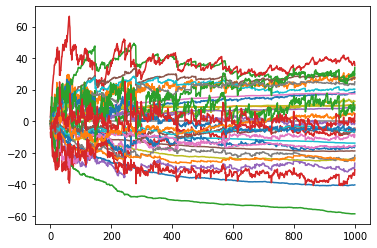

In [4]:
all_weights_array = np.stack(all_weights)
plt.plot(all_weights_array);

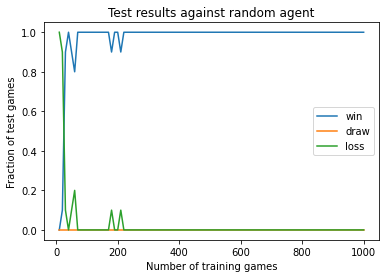

In [5]:
loss_rand = 1-np.array(test_results_rand)-np.array(test_draws_rand)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_rand,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_rand,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_rand,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against random agent');

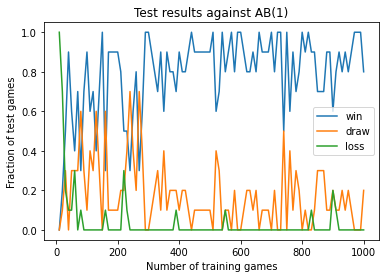

In [6]:
loss_1 = 1-np.array(test_results_1)-np.array(test_draws_1)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_1,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_1,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_1,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(1)');

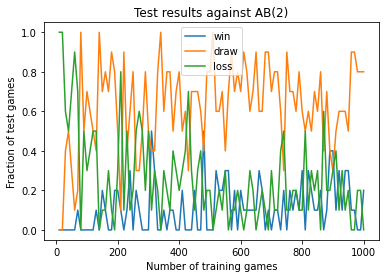

In [7]:
loss_2 = 1-np.array(test_results_2)-np.array(test_draws_2)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_2,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_2,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_2,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(2)');

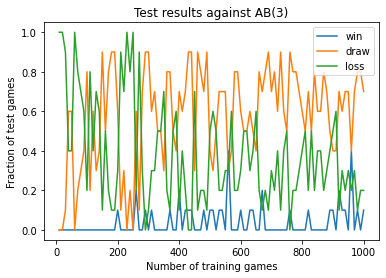

In [8]:
loss_3 = 1-np.array(test_results_3)-np.array(test_draws_3)
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_results_3,label='win'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),test_draws_3,label='draw'),
plt.plot(np.arange(test_frequency,n_train_games+1,test_frequency),loss_3,label='loss')
plt.legend()
plt.xlabel('Number of training games')
plt.ylabel('Fraction of test games')
plt.title('Test results against AB(3)');

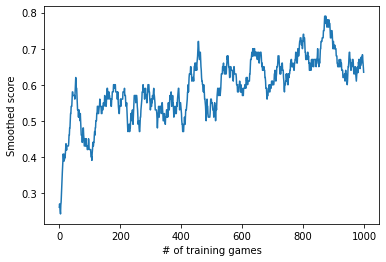

In [9]:
w = 50
calib = np.convolve(np.ones(n_train_games), np.ones(w), 'same')
all_score = 1*np.array(all_results) + 0.5*np.array(all_draws)
mean_smooth_score = np.convolve(all_score, np.ones(w), 'same') / calib
plt.plot(mean_smooth_score)
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

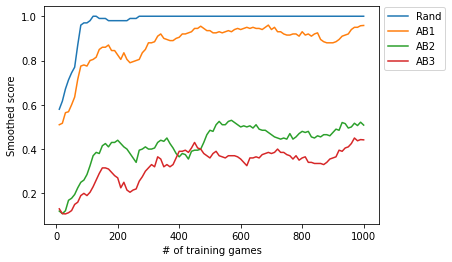

In [10]:
w = 10
calib = np.convolve(np.ones(len(test_results_rand)), np.ones(w), 'same')
all_score_rand = 1*np.array(test_results_rand) + 0.5*np.array(test_draws_rand)
all_score_1 = 1*np.array(test_results_1) + 0.5*np.array(test_draws_1)
all_score_2 = 1*np.array(test_results_2) + 0.5*np.array(test_draws_2)
all_score_3 = 1*np.array(test_results_3) + 0.5*np.array(test_draws_3)
mean_smooth_score_rand = np.convolve(all_score_rand, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_rand, label='Rand')
mean_smooth_score_1 = np.convolve(all_score_1, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_1, label='AB1')
mean_smooth_score_2 = np.convolve(all_score_2, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_2,label='AB2')
mean_smooth_score_3 = np.convolve(all_score_3, np.ones(w), 'same') / calib
plt.plot(np.arange(test_frequency,n_train_games+1, test_frequency),mean_smooth_score_3,label='AB3')
plt.legend(bbox_to_anchor=(1,1.02))
plt.xlabel('# of training games')
plt.ylabel('Smoothed score');

In [11]:
import pickle

data = {'all_results':all_results,
        'all_draws':all_draws,
        'all_oppn_idx':all_oppn_idx,
        'all_weights':all_weights,
        'all_num':all_num,
        'all_rewards':all_rewards,
        'test_results_rand':test_results_rand,
        'test_results_1':test_results_1,
        'test_results_2':test_results_2,
        'test_results_3':test_results_3,
        'test_draws_rand':test_draws_rand,
        'test_draws_1':test_draws_1,
        'test_draws_2':test_draws_2,
        'test_draws_3':test_draws_3}
with open(r"Sarsa_lambda_05_gamma_09.pkl", "wb") as f:
    pickle.dump(data, f)